<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/sherifmost/DeepLearning/blob/master/Labs/lab5/lab5.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab 5: Visual Image Caption Generation

![CNN RNN Image Captioning](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab5/Cover.png?raw=1)

## 5.1 Problem Statement

In this Lab you will build an encoder-decoder architecture with attention to address the task of image captioning on the Flickr 8k dataset.

The model is composed of the following main components:


1.   Encoder: we will be using an InceptionV3 model pre-trained on imagenet for extracting the image features.
2.   Attention Model: we will implement the [Bahdanau Attention Mechanism](https://machinelearningmastery.com/the-bahdanau-attention-mechanism/) and get introduced to how the mathematical operations learned in class are implemented using Tensorflow operations.
3.   Decoder: we will be using an RNN-based decoder using LSTM.


The dataset consists of 6000 training examples and 1000 testing examples, with different image sizes. **In this lab, you will also learn how to deal with loading such a large dataset to the RAM without crashing it.**

We will rely on qualitative evaluation of the model by making sure that the captions make sense on a random test image at the end!



**IMPORTANT NOTE:** You have to change runtime type on Google Colab to GPU since this lab requires much computation resources and it will run very slowly on CPU (Default runtime type)

Click on "Runtime" => "Change runtime type" => make sure that GPU is selected in the "Hardware accelerator"

Now lets walk through the code, and tell you the parts you need to fill. 

**MAKE SURE YOU KEEP THE OUTPUTS FOR THE SUBMISSION**

## 5.2 Problem Details

### 5.2.1 Importing Needed Packages

In [2]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
# This library is used for providing regex functionalities
import re
import time

### 5.2.2 The Flickr8k Dataset

In this assignment, we will be using the [Flickr8k dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k) which consists of 8000 images with 5 captions for each image. 

Let's download the dataset to the session and inspect it:

#### 5.2.2.1 Downloading the dataset

The dataset is obtained from this [github repo](https://github.com/jbrownlee/Datasets/releases/) containing the original dataset, and is downloaded to the current session under folder *content/datasets*. This will take some time when using the GPU instead of the CPU for the runtime. You only need to run this once when starting the session.

**Note that terminating the session loses the dataset (you will need to download it again by running this cell).**

In [3]:
# Obtaining the images from the repo
tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir = '.',
        extract=True)
# Obtaining the captions and the dataset splits from the repo
tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        extract=True)

2340801/2340801 [==============================] - 0s 0us/step


'./datasets/Flickr8k_text.zip'

**You can check that the dataset was downloaded by inspecting the files in the Colab navigation bar in the left**. You should find a *datasets* folder added and under which there are some text files and a *Flicker8k_Dataset* folder containing the images.

*Before continuing on, please make sure that the dataset was downloaded successfully to your session without any issues due to connection, etc. if you think there is an issue, try restarting the session and re-running the data downloading cell.*

The dataset is structured as follows:


*   Each image has a certain Id and is stored in JPG format
*   The text file *Flickr8k.token.text* contains the captions for each image, it follows the following format: < image_name >#< caption number >    < Caption >, where each image has up to 5 captions
*    The text files *Flickr_8k.trainImages.txt* and *Flickr_8k.testImages.txt* contain the image names for the training and testing splits respectively 



Now, lets define some useful directories to be used throughout the Lab:

In [4]:
# The main directory containing the dataset
dataset_dir = './datasets/'
# The directory to access the images
images_dir =  dataset_dir + 'Flicker8k_Dataset/'

#### 5.2.2.2 Loading the Dataset

**Note that the major bottleneck on the RAM is loading all the images at once, so instead we load the image names and their captions. Later we will see how we can use the image names to load the images in batches instead to avoid overflowing the RAM.**

Define a method to load the files

In [5]:
# Loads a file into a long string
def load_file(filename):
   with open(filename, "r") as fp:
    # Read and return all text in the file
    text = fp.read()
    return text

Define methods to prepare the captions

The format we will follow is to have a [dictionary](https://www.geeksforgeeks.org/python-dictionary/) mapping each image by its Id to a list of strings representaing the corresponding captions.

In [6]:
# Prepares a dictionary mapping each image Id to the corresponding captions
# This relies on the .split() method
# Takes as input the long text read from the file by the previous method
def prepare_captions_dict(text):
  
  captions_dict = {}
  # Split the file text into lines
  lines = text.split ('\n')

  # Process each line separately to extract the (image, caption) pair
  for line in lines:
    
    # Split into the <imageId> and <caption>
    line_split = line.split('\t')

    # Added this check because dataset contains some blank lines, they are ignored
    if (len(line_split) != 2):
      continue
    else:
      image, caption = line_split

    # Split into <image_name> and <caption_idx>
    image_name, caption_idx = image.split('#')
    # Split the <image_name> into <image_id>.jpg
    image_id = image_name.split('.')[0]
    
    # If this is the first caption for this image, create a new list for that
    # image and add the caption to it. Otherwise append the caption to the 
    # existing list
    if (int(caption_idx) == 0):
      captions_dict[image_id] = [caption]
    else:
      captions_dict[image_id].append(caption)
  
  return captions_dict

Define methods to load the image Ids of a certain split (training/validation/testing), given the read split file (like Flickr_8k.trainImages.txt) as text.

In [7]:
# This method gets the ids of images that correspond to a certain split
# It takes the read split file as a text
def get_split_image_ids(text):
    
    ids = []
    # Split the file text into lines
    lines = text.split ('\n')
    for line in lines:
      # skip any empty lines
      if (len(line) < 1):
        continue
      
      # Each line is the <image_name>
      # Split the <image_name> into <image_id>.jpg
      image_id = line.split ('.')[0]
    
      # Add the <image_id> to the list
      ids.append(image_id)

    return set(ids)  

Define methods to load the image file (they will be used to visualize the images, and later on when loading the dataset for training)

In [8]:
# This method loads an image as it is (mainly used for visualization purposes)
# Note that we use RGB images so the channels should be set to 3
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [9]:
# This method loads a single image, resizes it to a certain size
# then, preprocess_input of inception_v3 is used to preprocess the images
# You can read more about it here: https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input
def load_preprocess_image(image_path, image_size = (299,299)):
  img = load_image(image_path)
  img = tf.image.resize(img, image_size)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

Loading the captions dictionary, the training, and the testing image Ids

In [10]:
# preparing the captions dictionary
captions = prepare_captions_dict(load_file(dataset_dir + 'Flickr8k.token.txt'))

In [11]:
# preparing the dataset split ids
training_image_ids = get_split_image_ids(load_file(dataset_dir + 'Flickr_8k.trainImages.txt'))
test_image_ids = get_split_image_ids(load_file(dataset_dir + 'Flickr_8k.testImages.txt'))
print('Number of training images: {}'.format(len(training_image_ids)))
print('Number of testing images: {}'.format(len(test_image_ids)))

Number of training images: 6000
Number of testing images: 1000


#### 5.2.3 Visualizing the Dataset

You can run it different times to see other samples at random. Feel free to check different samples and see their captions!

Captions:
A black dog running through the snow .
a black dog runs across the snow .
A black dog wearing a blue collar is running through the snow .
A black dog with a blue collar is running in the snow .
The black dog has a blue collar on .

Image:


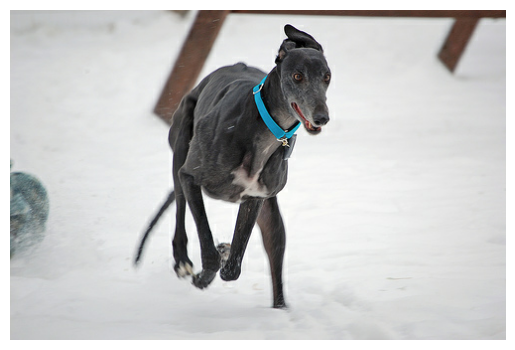

In [12]:
# Selecting a random training image Id and loading the image
random_image_id = random.choice(tuple(training_image_ids))
random_image_path = images_dir + random_image_id + '.jpg'
random_image = load_image(random_image_path)

# Printing the corresponding captions using the dictionary
print('Captions:')
for caption in captions[random_image_id]:
  print(caption)

# Displaying the image
plt.axis('off')
plt.imshow(random_image)
print('\nImage:')

### 5.2.3 Processing the Data for Image Captioning

First, let's take a step back and consider what we are doing...
We have some images and their corresponding text captions that we want to learn how to predict automatically. We are using an encoder-decoder architecture for this, but why? 

We want the encoder to extract the features of the images to have a more informative representation for the model. This representation can then be processed to generate the captions. However, using a simple fully-connected layer to generate the captions will be less likely to generate a linguistically correct caption, thus we rely on an RNN-based decoder that takes into consideration the previously predicted word in the caption when predicting the next word. Finally, we also incorporate an attention mechanism to improve the model performance by making it focus on the important parts in the image.

To do this, we need two main operations on the data before training the model:


*   Encode the images: this is just another way of saying extract features from them, and store those extract features to be used later on. 
*   Encode the captions: captions are originally formatted as text, however, our models cannot work directly with string representations. Thus, we need to convert the captions to a numerical representation. To do so, we extract a vocabulary from the training captions and map each element in the vocabulary to a numerical representation according to its index.



#### 5.2.3.1 Encoding the Images using a Pretrained CNN

We use the [InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3) CNN pre-trained on ImageNet. As we are working on normal real-life images, using the pre-trained version on imagenet makes sense.

We will use the functional API [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) to initialize the feature extractor in a flexible and extensible way (**in case you wanted to combine it with the decoder later on and have an e2e encoder-decoder that can be trained in its entirety. This is not required in the assignment.**).

**TODO:** Fill in the following code cell by initializing an InceptionV3 model pre-trained on imagenet. **Make sure to remove the classifier part at the top of the model.**

In [13]:
# Using a pre-trained InceptionV3 without the classifier part
feature_extractor = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
feature_extractor_model = tf.keras.Model(feature_extractor.input, feature_extractor.layers[-1].output)

87910968/87910968 [==============================] - 0s 0us/step


We now encode the images by loading the training images, extracting their features using the feature_extractor_model we defined and storing the extracted features as numpy files for later use.

*The encoded files will be stored in the same directory of the original images with the same name for convenience along with a suffix of .npy to differentiate them from the original image files.*

Not to crash the RAM, we will be using the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to load the images, and do the following steps:


1.   Define a certain batch_size to be loaded each time (instead of loading the whole images at once)
2.   Instantiate a tf.data.Dataset variable by slicing the train_paths into single tensors, using [tf.data.Dataset.from_tensor_slices](https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/) 
3.   Using  [.map()](https://www.geeksforgeeks.org/tensorflow-js-tf-data-dataset-map-function/) operation to map the train_paths tensors to the corresponding images using the load_preprocess_image as the transform function
4.   Using [.batch()](https://www.geeksforgeeks.org/tensorflow-js-tf-data-dataset-class-batch-method/) and passing in the batch_size to obtain images in batches

If you feel confused still, please check this awesome [article](https://cs230.stanford.edu/blog/datapipeline/#:~:text=An%20overview%20of%20tf.data%20The%20Dataset%20API%20allows,creates%20batches%20and%20sends%20it%20to%20the%20GPU.) on how to build an efficeint dataset pipeline using tf.data. I recommend you read the *Building an image data pipeline* section carefully.

After that, we use [tqdm](https://tqdm.github.io/) to loop on the batches along with a visual representation of the progress.



**TODO:** Fill in the missing code parts in the cell to complete the data loading process and encode the images. **Use the previous hints as guidelines.**

In [14]:
# Preparing the training image paths
training_image_paths = [images_dir + image_id + '.jpg' for image_id in training_image_ids]

# remove any duplications
train_paths = sorted(set(training_image_paths))

# Load the images in batches using the steps detailed above
# Feel free to experiment with the batch_size and see the effect on RAM and execution time
batch_size = 16

image_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
image_dataset = image_dataset.map(load_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
image_dataset = image_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Loop on the image batches using tqdm (we loop on the batches themselves obtained using the image_dataset variable)
for batch_img, batch_path in tqdm(image_dataset):
  # Use the encoder to extract features from the current batches
  batch_features = feature_extractor_model(batch_img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  # Store the encoded images at the same path and add in a suffix of .npy (we loop now for each image in the batch)
  for bf, p in zip(batch_features, batch_path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
  
print('\n\nCompleted Encoding the training images, encoded version has same name and path as the original with a suffix of .npy')

100%|██████████| 375/375 [02:21<00:00,  2.64it/s]



Completed Encoding the training images, encoded version has same name and path as the original with a suffix of .npy


#### 5.2.3.2 Encoding the Captions used for Training

![CNN RNN Image Captioning](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab5/Encoding_Captions.png?raw=1)

This is done by the following steps:


*   Pre-process and clean the captions text: 

   *   Convert all the text to lower cases to have a unified representation of the words
   *   Remove any punctuation and words which are one character or less in length (such as 'a' and ' ')
   *   Remove any alphanumeric symbols (any words with numbers in them)
   *   Add in a starting and ending token to represent the start and end of the caption sentence.

*   Obtain only the training captions to get the vocabulary from (we shouldn't leak any information from the testing set so the training set is used for this)

*   Tokenize the training captions to prepare a vocabulary of the used words encoded numerically

##### Preprocessing and cleaning the captions

Using [re](https://docs.python.org/3/library/re.html) to perform regex operations for cleaning the captions

In [15]:
# This function processes the captions inplace
# Takes as input the dictionary mapping the image Ids to the corresponding captions
def captions_clean(caption_dict):

  for _, captions in caption_dict.items():
    
    # Loop through each caption for each image
    for i, caption in enumerate(captions):
      
      # Convert the caption to lowercase, and then remove all special characters from it (those having only one character)
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
      
      # Split the caption into separate words, and collect all words which are more than 
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
      
      # Join those words into a string
      caption_new = ' '.join(clean_words)
      
      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new

Adding in start and end tokens for the captions

In [16]:
# The tokens constant definition, used throughout the notebook
START_TOKEN = 'starttok'
END_TOKEN = 'endtok'

In [17]:
def add_tokens(captions):
  for i, caption in enumerate (captions):
    captions[i] = START_TOKEN + ' ' + caption + ' ' + END_TOKEN
  return captions

##### Divide the captions according to the dataset splits

In [18]:
# Used to get the captions corresponding to a certain split of the dataset (training/testing)
# Will be used when calling the functions to obtain the training split 
def subset_caption_dict (caption_dict, image_Ids):
  dict = { image_Id:add_tokens(captions) for image_Id,captions in caption_dict.items() if image_Id in image_Ids}
  return dict

##### Tokenizing the captions

Fitting a [Keras tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to the captions to be used to get the numeric representations of the captions

**TODO:** fill in the missing code to perform the tokenization on the captions.

In [19]:
def create_tokenizer(caption_dict):
  # Get a flat list of all the captions from the dictionary
  captions = [caption for key, captions in caption_dict.items() for caption in captions]
  
  # Getting the number of words in the caption with the most words
  max_caption_words = max(len(caption.split()) for caption in captions)

  # Initialise a Keras Tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=' ',
        char_level=False,
        oov_token=None,
        analyzer=None,
    )  
  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)

  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return tokenizer, vocab_size, max_caption_words

Pad a list of text indeces to a fixed length. Why do we need this?

We want a fixed-length vector numerical representation of the captions, however, captions have different lengths. A solution would be to pad all captions by zeros to have a fixed-length equal to the length of the caption with the maximum number of words (obtained from the previous function). Padding by zero here indicates that there are no words in this index of the vector representation.

Done using [pad_sequences](https://tensorflow.google.cn/api_docs/python/tf/keras/utils/pad_sequences) of keras.

**TODO:** Fill in the following cell to perform the padding

In [20]:
def pad_text(text, max_length): 
  '''TODO: call pad_sequences with the appropriate parameters. 
            Note that the seqeunces parameter expects a list of sequences (list of texts), that's why I passed [text] and not text
            Similarly, it returns a list of padded texts, thtat's why I return pad_sequences()[0]
            You need to define the maxlen parameter
            We want the padding to be at the end of the seqeunce (hint: look into the padding parameter possible values)
  '''

  text = pad_sequences([text], maxlen = max_length
                       , padding='post')[0]
  return text

##### Performing the function calls on the captions dictionary

In [21]:
# This function processes the captions inplace
captions_clean(captions)
training_dict = subset_caption_dict(captions, training_image_ids)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

### 5.2.4 Obtaining the Input/Output Data for Training

Remember that the data is lazily loaded to prevent memory issues, to do so we first prepare training (x,y) pairs where x is the image file path and y are the corresponding cleaned and tokenized captions.

Then, we wil use tf.data to load the images in batches similar to what was done when using InceptionV3 to perform feature extraction earlier.

In [22]:
#  Getting the training X and Y pairs 
def data_prep(caption_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_id, captions in caption_dict.items():
    image_id = images_dir + image_id + '.jpg'

    # For each caption in the list of captions
    for caption in captions:

      # Convert the caption words into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_text(word_idxs, max_length)
          
      X.append(image_id)
      y.append(pad_idxs)
  
  return X, y

train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

Load the pre-processed encoded images saved in an earlier stage (the ones encoded using the pre-trained CNN)

*Done using tf.data with the same approach as in the feature extractor part when encoding the images.*

**Please refer back to this section and follow the same steps indicated there.**

The main difference here is that the tensors we are working on are the pairs (X,Y). This will change the way we specify the arguments of the from_tensor_slices(). Also this changes how we use the map() operation, the mapping function now returns a pair of variables (the image and the corresponding caption), thus we use the [lambda expression](https://www.geeksforgeeks.org/python-lambda/) along with the [tf.numpy_function](https://www.tensorflow.org/api_docs/python/tf/numpy_function) to define the mapping function.

**TODO:** Fill in the cell to perform the lazy data loading similar to what you did before.

In [23]:
# Feel free to experiment with different batch sizes
BATCH_SIZE = 128
BUFFER_SIZE = 1000

# Mapping function used to Load the encoded image files (the extracted features)
def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

# Obtaining Input/Output pair slices from the X and Y lists
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
# Use map to load the encoded image files
# TODO: Fill in the map() call to call the mapping function
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
)

# Shuffle and Batch the dataset
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

# Prefetch from the dataset
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### 5.2.5 The Encoder-Decoder Model with Attention and Pre-trained Encoder

The model is prepared through the use of [python classes](https://www.geeksforgeeks.org/python-classes-and-objects/) for ease of re-usability and extensibility.

The model consists of the following main modules


*   Encoder to encode the images.
*   Attention to focus on the important image features.
*   Decoder to predict the caption.

The decoder outputs a **probability distribution** over the vocabulary for each timestep to predict the word of this timestep. We will use from_logits = True in the loss when training the model, hence the output of the decoder won't have a softmax activation.




![Model](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab5/Model_full.png?raw=1)


#### 5.2.5.1 Encoder

As we already encoded the images using a pre-trained CNN, this module is very simple. We just add a Fully Connected [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer after the encoded images we saved.

**TODO:** Fill in the code to define the encoder

In [24]:
class Pretrained_Encoder(tf.keras.Model):
    # Since we have already extracted the features and saved them
    # We just pass the features through a fully connected dense layer
    def __init__(self, embedding_dim):
        super(Pretrained_Encoder, self).__init__()
        # shape after fc ==> (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(units = embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

#### 5.2.5.2 Attention

For the attention layer, we implement the [Bahdanau Additive Attention Mechanism](https://machinelearningmastery.com/the-bahdanau-attention-mechanism/), this follows similar operations to what you learned in class.

We use the following tensorflow methods for the implementation:


*   [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers to represent the weights used in the calculations
*   [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims): to give the previous state an extra dimension representing the time axis
*   [tf.math.tanh](https://www.tensorflow.org/api_docs/python/tf/math/tanh) and [tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) to perform the tanh and softmax operations
*   [tf.math.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) to get the weighted sum at the end of the calculation



![Model](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab5/Additive_Attention.png?raw=1)

**TODO**: Fill in the code to define the attention mechanism following the figure above

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    # These dense layers will be used as the weights used in the additive attention calculations 
    # Note that the dense layers shouldn't have an activation as the activation functions are called later according to the figure
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    # This is the weight variable for the tanh activation
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, prev_state):
    # features i.e: encoder output, shape ==> (batch_size, 64, embedding_dim)

    # prev_state shape ==> (batch_size, prev_state_size)
    # prev_state_with_time_axis shape ==> (batch_size, 1, prev_state_size)
    prev_state_with_time_axis = tf.expand_dims(prev_state, 1)

    # First, calculating the score using the encoded features and the previous state
    
    # attention_hidden_layer shape ==> (batch_size, 64, units)
    # This layer represents tanh(W1.h + W2.s_(t-1))

    attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(prev_state_with_time_axis))

    # score ie: e in the figure, shape ==> (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    # This layer represents VT(tanh(W1.h + W2.s_(t-1)))



    score = self.V(attention_hidden_layer)

    # Second, calculating the attention weights from the obtained scores

    # attention_weights ie: alpha in the figure, shape == (batch_size, 64, 1)
    # Applying a softmax to the scores gives the corresponding weight value
    attention_weights = tf.nn.softmax(score, axis=1)

    # Third, multiplying the features with the attention weights and obtaining the weighted sum

    # context_vector ie: c_t in the figure, shape after sum == (batch_size, prev_state_size)
    # context_vector = '''TODO: Mutiply the attention weights with the features'''
    context_vector = attention_weights * features
    
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#### 5.2.5.3 Decoder

An RNN-based decoder using LSTMs using:


*   [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): an embedding layer to embed the words using the vocabulary processed by the tokenizer in the previous steps, converting them into fixed-size dense vectors based on the vocabulary indeces.
*   [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): for the LSTM model of the decoder
*   [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers: to output the predicted word per step from the vocabulary. **Note that the predicted caption is a sequence of predicted words from the vocabulary.**

*   The attention model we defined above
*   [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat): to concatenate the context vector with the output of the previous step




![Model](https://github.com/sherifmost/DeepLearning/blob/master/Labs/lab5/Decoder_LSTM.png?raw=1)

**TODO:** Fill in the code to define the decoder.

In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    # Number of units used for the LSTM and the first dense layer
    self.units = units

    # The embedding layer for the words
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # The lstm layer

    self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')  
  

    # A hidden dense layer
    self.fc1 = tf.keras.layers.Dense(self.units)
    
    # The output dense layer of the Decoder

    # self.fc2 = '''TODO: Define the output dense layer with the correct number of outputs
    #               HINT: What is the number of possible words to output?'''

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # The attention layer to be used
    self.attention = BahdanauAttention(self.units)
  
  # y here represents the output of the previous step at first
  # after the processing, it will include the output of this step
  # think of it as a recursive process
  def call(self, y, features, prev_state):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, prev_state)
    
    # y shape after passing through embedding ==> (batch_size, 1, embedding_dim)
    # passing the output of the previous step to the embedding layer
    y = self.embedding(y)

    # y shape after concatenation ==> (batch_size, 1, embedding_dim + state_size)
    # Cncatenate y with the context_vector obtained through the attention mechanism
    y = tf.concat([tf.expand_dims(context_vector, 1), y], axis=-1)

    # passing the concatenated vector to the LSTM
    # we will use the output in the next layers, the state will be returned to be used in the attention for the next step
    # The third returned variable is the last cell state, we will only use the last hidden state for the state variable
    output, state, _ = self.lstm(y)

    # shape ==> (batch_size, max_length, hidden_size)
    # pass the LSTM output to the hidden layer
    y = self.fc1(output)

    # y shape ==> (batch_size * max_length, hidden_size)
    # reshape y 
    y = tf.reshape(y, (-1, y.shape[2]))

    # output shape ==> (batch_size * max_length, vocab_size)
    y = self.fc2(y)

    return y, state

  # This is used to reset the state of the LSTM 
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

### 5.2.6 Training the Model 

To train the model, we will rely on tensorflow operations, with the following steps:

#### 5.2.6.1 Initializing the Encoder and the Decoder

In [27]:
# Dense layer units of the encoder 
# and the embedding dimension of the embedding layer in the decoder
embedding_dim = 256
# LSTM units
units = 512
# The number of training steps per epoch
num_steps = len(train_X) // BATCH_SIZE
# The vocab_size (obtained a few steps back)
vocab_size = vocab_size
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [28]:
# Initializing the Encoder and the Decoder
encoder = Pretrained_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

#### 5.2.6.2 Defining the training process

We will be using adam optimizer and [sparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). As we set from_logits = True in the loss, there is no need to add softmax activation in the output dense layer of the decoder (as mentioned before).

In [29]:
# Loss and optimizer used
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

A question here, do we want to penalize the model if it doesn't predict a padding in the captions? No, as captions have varying lengths so we only want to penalize the model in case the ground truth caption had a word in this step. To do so we will need to implement a basic custom loss function.

Let's use tf operations to implement the loss function based on sparseCategoricalCrossentropy. To do so, follow the steps:


*   Define a mask by checking that the ground truth (real) is not equal to zero using [tf.math.logical_not](https://www.tensorflow.org/api_docs/python/tf/math/logical_not) and [tf.math.equal](https://www.tensorflow.org/api_docs/python/tf/math/equal) => we don't want to penalize wrongly predicted paddings
*   Calculate the custom loss as the sparseCategoricalCrossentropy between the real and the predicted using the loss_object we defined
*   Apply the mask by multiplying the loss with it. By this we only calculate the sparseCategoricalCrossentropy for the parts that aren't paddings.
*   Return the average of the loss by using [tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean)



**TODO:** Fill in the code to define the custom loss function

In [30]:
# The loss function used
def loss_function(real, pred):
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))  

  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Now, lets implement the full training step. We will mainly rely on the loss function we just implemented and on [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape). The training step calculates the loss and performs the weight updates for a single batch of trainnig samples.

We will also use [teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/) when training the decoder for a more stable training by using the previous timestep from the ground truth not from the predictions.

**TODO:** Fill in the code to complete the training process

In [31]:
@tf.function
def train_step(img_tensor, target, encoder, decoder):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image, so we need to reset the state 
  state = decoder.reset_state(batch_size=target.shape[0])

  # The first token to be given to the decoder is the START_TOKEN
  dec_input = tf.expand_dims([tokenizer.word_index[START_TOKEN]] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # Call the encoder model on the image to get the encoded features
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, state = decoder(dec_input, features, state)

          # Append to the loss the current loss calculated between the predictions and the ground truth target up to this point
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing 
          dec_input = tf.expand_dims(target[:, i], 1)

  # Get the average loss
  total_loss = (loss / int(target.shape[1]))

  # The trainable variables to be passed to the gradient tape are both the encoder and decoder trainable variables

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # pass the trainable variables and the loss to the gradient tape
  gradients = tape.gradient(loss, trainable_variables)

  # Use the optimizer to apply gradient decent and update the weights of the trainable variables
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

Perform the training and monitor the loss. To perform the training, we call the training step for each batch of each epoch. The training batches are lazily loaded using the dataset variable we defined a few steps back when obtaining the input/output data for training (the batch size was defined in that step too).

**TODO:** Run this cell and keep the output.

In [32]:
start_epoch = 0
EPOCHS = 20
loss_plot = []

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for this epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.6659
Epoch 1 Batch 100 Loss 1.5964
Epoch 1 Batch 200 Loss 1.3763
Epoch 1 Loss 1.575235
Time taken for this epoch 150.45 sec

Epoch 2 Batch 0 Loss 1.2950
Epoch 2 Batch 100 Loss 1.2532
Epoch 2 Batch 200 Loss 1.1111
Epoch 2 Loss 1.214937
Time taken for this epoch 56.49 sec

Epoch 3 Batch 0 Loss 1.2296
Epoch 3 Batch 100 Loss 1.1371
Epoch 3 Batch 200 Loss 0.9788
Epoch 3 Loss 1.086420
Time taken for this epoch 57.54 sec

Epoch 4 Batch 0 Loss 1.0360
Epoch 4 Batch 100 Loss 0.9891
Epoch 4 Batch 200 Loss 0.9567
Epoch 4 Loss 1.000288
Time taken for this epoch 56.43 sec

Epoch 5 Batch 0 Loss 1.0559
Epoch 5 Batch 100 Loss 0.9304
Epoch 5 Batch 200 Loss 0.8356
Epoch 5 Loss 0.934450
Time taken for this epoch 58.15 sec

Epoch 6 Batch 0 Loss 0.8841
Epoch 6 Batch 100 Loss 0.8702
Epoch 6 Batch 200 Loss 0.8500
Epoch 6 Loss 0.878815
Time taken for this epoch 55.72 sec

Epoch 7 Batch 0 Loss 0.8618
Epoch 7 Batch 100 Loss 0.8582
Epoch 7 Batch 200 Loss 0.7640
Epoch 7 Loss 0.830150
Time ta

Plot the loss to make sure that nothing wrong happened while training

**TODO:** Run this cell and keep the output.

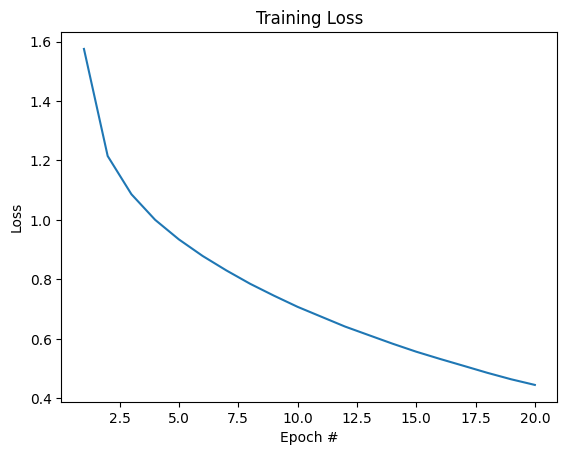

In [33]:
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.plot(np.arange(1,21),loss_plot)
plt.show()

### 5.2.7 Evaluating the Model

We will rely on qualitative evaluation by inspecting the output captions corresponding to random test images.

In [34]:
# This method takes an image and obtains the predicted captions
# This is done by using the encoder and decoder models and obtaining the predicted words by sampling from 
# the predicted random distribution output by the decoder at each time step.
# The predicted word of timestep i is passed to timestep i+1 along with the extracted image features to predict the next word.
# The predictions stop when the model outputs END_TOKEN or when it outputs a caption with the maximum length. 
def evaluate(image, max_length, encoder, decoder):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_preprocess_image(image)[0], 0)
    img_tensor_val = feature_extractor_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index[START_TOKEN]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder(dec_input,
                                      features,
                                      hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == END_TOKEN:
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [35]:
def check_test(test_image_names, image_dict, image_dir, max_caption_words, encoder, decoder):
  # captions on the validation set
  rid = np.random.randint(0, len(test_image_names))
  image_name = test_image_names[rid]

  real_caption = image_dict[image_name]

  image_path = image_dir + image_name + '.jpg'
  result = evaluate(image_path, max_caption_words, encoder, decoder)

  # Displaying the image
  original_image = load_image(image_path)
  plt.axis('off')
  plt.imshow(original_image)
  print('Real Captions:')
  for caption in real_caption:
    print(' ' + caption)
  print('\nPrediction Caption:\n', ' '.join(result))
  return result

Test the model on a random image from the testing set, run the following cell different times to see predictions for different random test images!

Neglect the start and end tokens in the output predicted captions if they are outputted.

**Feel free to experiment more with the model parameters and training time to generate even better captions!**

**TODO:** Run this cell and keep the output

Real Captions:
 brown and white pitbull with black collar is about to leap over branch
 brown dog climbs over fallen branch in wooded area
 brown dog hops over fallen tree branch
 brown dog is jumping over tree limb in wooded area
 brown dog with white mark in chest and black collar going over limb on ground

Prediction Caption:
 brown and white dog is jumping in the dirt endtok


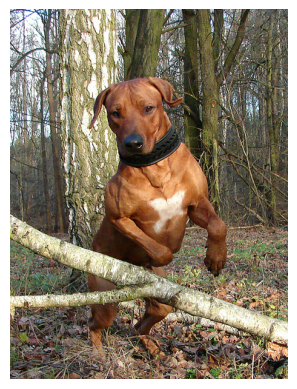

In [39]:
test_image_name_file = dataset_dir + "Flickr_8k.testImages.txt"
test_image_ids = get_split_image_ids(load_file(test_image_name_file))
result = check_test(list(test_image_ids), captions, images_dir, max_caption_words, encoder, decoder)

## 5.3 Conclusion

That's it! Congratulations on training an image captioning model.

Make sure you deliver all the requirements for the submission.